In [1]:
import numpy as np
import timeit
import numexpr as ne
from numba import njit
import matplotlib.pyplot as plt

(5000, 2, 50)
Std noise: 0.0
SNR = inf
Std noise: 0.10056483254537028
SNR = 1.2966759522139057
Std noise: 0.19898841111778592
SNR = 0.6553145445380393
Std noise: 0.30402411359529374
SNR = 0.42891334656955504
Std noise: 0.40027562561587404
SNR = 0.32577551980429315
Std noise: 0.5032090537308053
SNR = 0.2591368319651861
Std noise: 0.5961089536491839
SNR = 0.21875195667123246
Std noise: 0.6917990326101686
SNR = 0.1884940479144626
Std noise: 0.7889050509902841
SNR = 0.16529238827449969
(30000, 2, 9)
1


/var/folders/g0/5d6w6vqx2yv2b3fqgwsh6xfr0000gn/T/ipykernel_27474/2799109067.py:20: RuntimeWarning: divide by zero encountered in scalar divide
  print(f'SNR = {13.04/(100*np.std(addedNoise[:,0,i]))}')


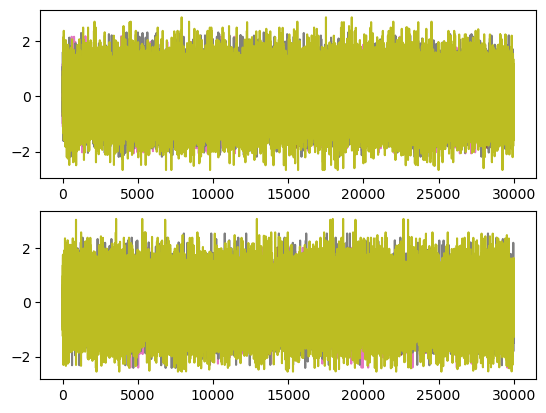

In [2]:
noiseArray = np.load('./functions/holdArrays/noiseSamples.npy')

#Randomly select noise samples from existing noise array 
noiseSize = np.shape(noiseArray)
print(noiseSize)
noReps = 3000
noSamps = 10
noLevels = 9
noiseSamples = np.random.choice(int(noiseSize[0]),[noReps*noSamps])
fig, axs = plt.subplots(2)
noOfIsochromatsX = 1000 #1000
noOfIsochromatsY = 1
noOfIsochromatsZ = 10
mult = 1 #noOfIsochromatsX*noOfIsochromatsY*noOfIsochromatsZ*(1/noOfIsochromatsX*noOfIsochromatsY)
addedNoise = mult*noiseArray[noiseSamples,:,:noLevels]
for i in range(addedNoise.shape[2]):
        axs[0].plot(addedNoise[:,0,i])
        axs[1].plot(addedNoise[:,1,i])
        print(f'Std noise: {np.std(addedNoise[:,0,i])}')
        print(f'SNR = {13.04/(100*np.std(addedNoise[:,0,i]))}')

print(addedNoise.shape)
print(mult)

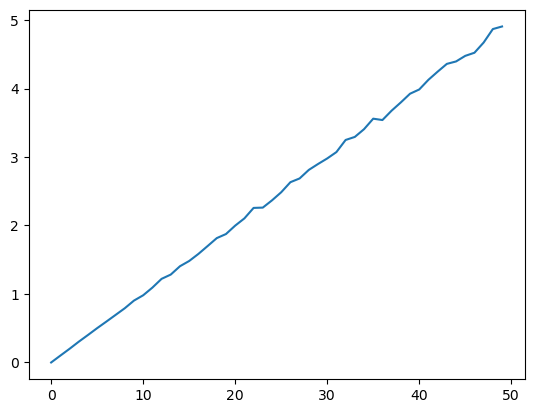

In [3]:
std_sample = np.zeros(noiseArray.shape[2])
for i in range(noiseArray.shape[2]):
    std_sample[i] = np.std(noiseArray[:,0,i])

plt.plot(std_sample)

Mx std noise: 0.09848117706686703
My std noise: 0.09848117706686703
Mx std noise: 0.32641944636942904
My std noise: 0.32641944636942904
Mx std noise: 0.5482718245348123
My std noise: 0.5482718245348123
Mx std noise: 0.7696590274765737
My std noise: 0.7696590274765737
Mx std noise: 0.9955276508212172
My std noise: 0.9955276508212172
(5000, 2, 5)


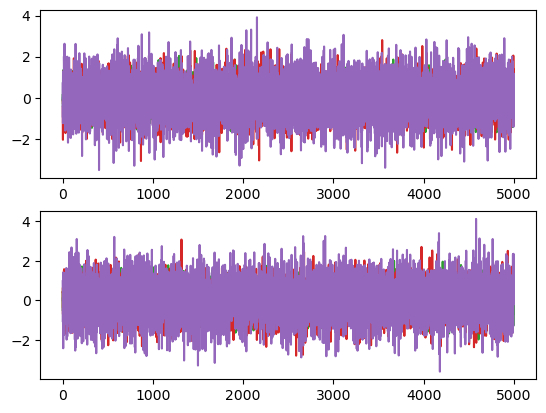

In [4]:
# Generate zero-mean Gaussian noise with a variable standard deviation
noLevels = 5
std_devs = np.linspace(0.1, 1.0, noLevels)  # Example standard deviations
generatedNoise = np.array([np.random.normal(0, std, (noiseSize[0], noiseSize[1])) for std in std_devs])
generatedNoise = np.transpose(generatedNoise, (1, 2, 0))  # Transpose to match the shape (samples, features, levels)

fig, axs = plt.subplots(2)
for i in range(generatedNoise.shape[2]):
        axs[0].plot(generatedNoise[:,0,i])
        axs[1].plot(generatedNoise[:,1,i])
        print(f'Mx std noise: {np.std(generatedNoise[:,0,i])}')
        print(f'My std noise: {np.std(generatedNoise[:,0,i])}')

print(generatedNoise.shape)

## Test the simulated signal mean versus a theoretical signal

Pulse sequence Bernstein book and https://core.ac.uk/download/pdf/210856108.pdf

In [5]:
import numpy as np

def ssfp_fid(M_0, theta, E_1, E_2):
    # Convert theta from degrees to radians if necessary
    theta_rad = np.radians(theta) 
    
    # Compute p and q based on the new definitions
    p = 1 - E_1 * np.cos(theta_rad) - E_2**2 * (E_1 - np.cos(theta_rad))
    q = E_2 * (1 - E_1) * (1 + np.cos(theta_rad))
    
    # Compute the SSFP_FID expression
    result = (M_0 * np.tan(theta_rad / 2) * 
              (1 - ((E_1 - np.cos(theta_rad)) * (1 - E_2**2)) / np.sqrt(p**2 - q**2)))
    
    return result

# Example usage
M_0 = 10000.0  # example value
theta = 50 # in degrees
TR = 40
T2 = 71 # tissue
T1 = 1122 # tissue
E_1 = np.exp(-TR/T1)  
E_2 = np.exp(-TR/T2) 


result = ssfp_fid(M_0, theta, E_1, E_2)
print("SSFP_FID:", result)

SSFP_FID: 948.1175143936051


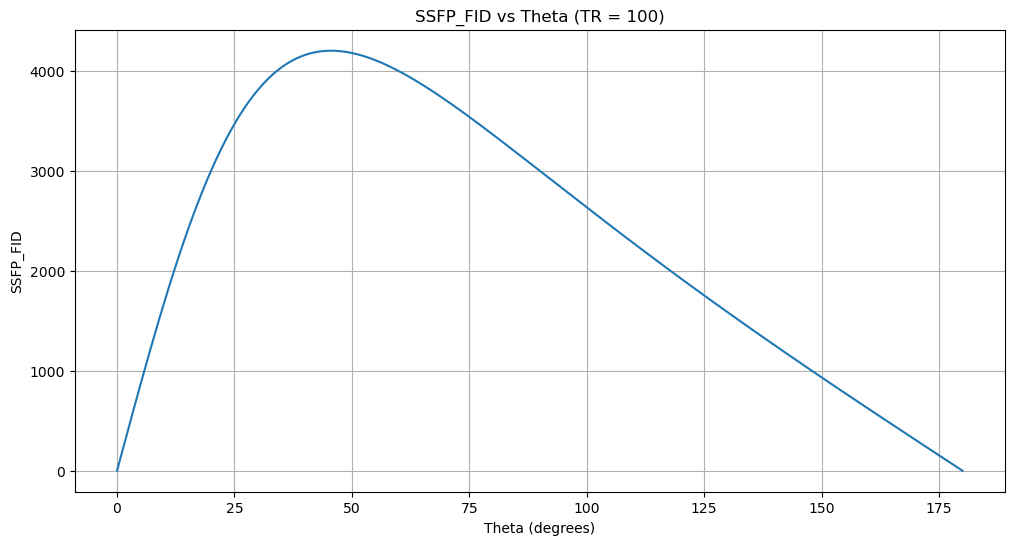

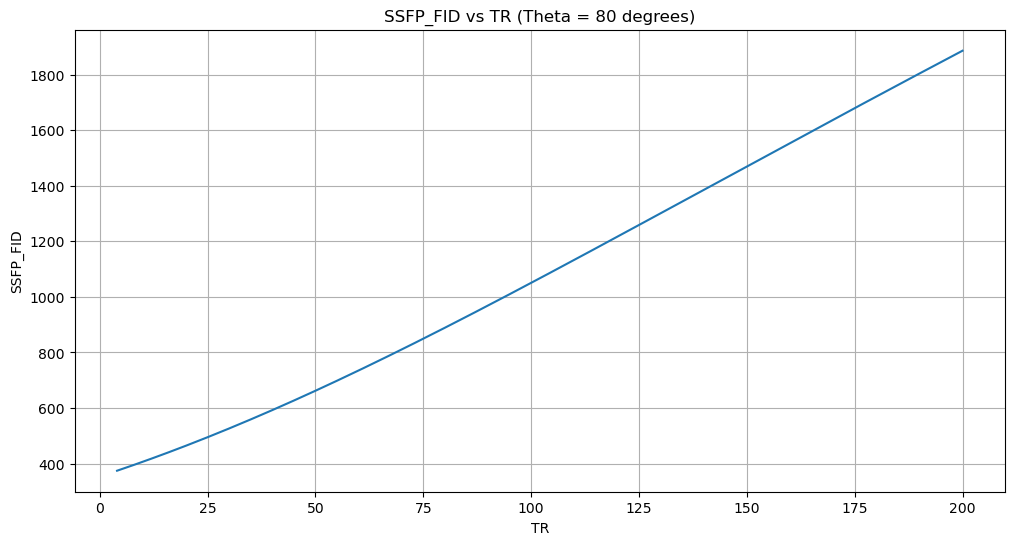

4.022346368715084


In [6]:
# Example values
M_0 = 10000 #10000.0
T2 = 71 # tissue
T1 = 1122 # tissue

# Plot for variable theta (0-180 degrees) with fixed TR = 100
theta_values = np.linspace(0, 180, 180)
TR_fixed = 400
E_1_fixed = np.exp(-TR_fixed / T1)
E_2_fixed = np.exp(-TR_fixed / T2)
ssfp_fid_values_theta = [ssfp_fid(M_0, theta, E_1_fixed, E_2_fixed) for theta in theta_values]

plt.figure(figsize=(12, 6))
plt.plot(theta_values, ssfp_fid_values_theta)
plt.xlabel('Theta (degrees)')
plt.ylabel('SSFP_FID')
plt.title('SSFP_FID vs Theta (TR = 100)')
plt.grid(True)
plt.show()


# Plot for variable TR (4 to 200) with fixed theta = 80
TR_values = np.linspace(4, 200, 197)
theta_fixed = 80
ssfp_fid_values_TR = [ssfp_fid(M_0, theta_fixed, np.exp(-TR / T1), np.exp(-TR / T2)) for TR in TR_values]

plt.figure(figsize=(12, 6))
plt.plot(TR_values, ssfp_fid_values_TR)
plt.xlabel('TR')
plt.ylabel('SSFP_FID')
plt.title('SSFP_FID vs TR (Theta = 80 degrees)')
plt.grid(True)
plt.show()

thet20 = theta_values[:5]
print(theta_values[np.argmax(ssfp_fid_values_theta[:5])])

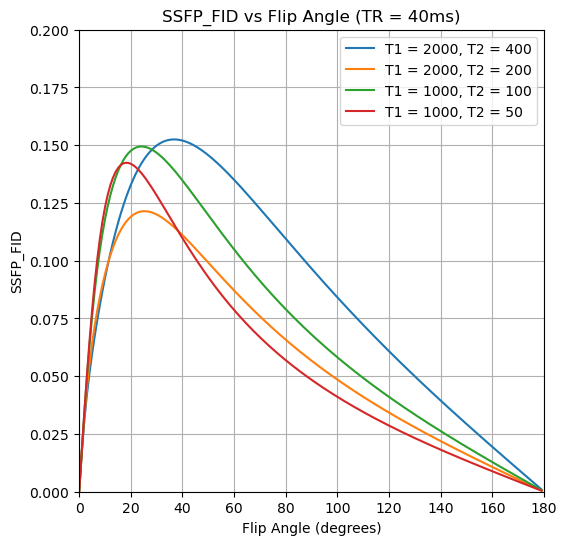

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Example values
M_0 = 1  # 10000.0

# Define the sets of T1 and T2 values
T1_T2_pairs = [
    (2000, 400),
    (2000, 200),
    (1000, 100),
    (1000, 50)
]

# Initialize lists to store results for plotting
theta_results = []
TR_results = []

# Loop through each pair of T1 and T2 values
for T1, T2 in T1_T2_pairs:
    # Plot for variable theta (0-180 degrees) with fixed TR = 100
    theta_values = np.linspace(0, 180, 180)
    TR_fixed = 40
    E_1_fixed = np.exp(-TR_fixed / T1)
    E_2_fixed = np.exp(-TR_fixed / T2)
    ssfp_fid_values_theta = [ssfp_fid(M_0, theta, E_1_fixed, E_2_fixed) for theta in theta_values]
    theta_results.append((theta_values, ssfp_fid_values_theta, T1, T2))

# Plot all theta results on the same graph
plt.figure(figsize=(6, 6))
for theta_values, ssfp_fid_values_theta, T1, T2 in theta_results:
    plt.plot(theta_values[:179], ssfp_fid_values_theta[:179], label=f'T1 = {T1}, T2 = {T2}')
plt.xlabel('Flip Angle (degrees)')
plt.ylabel('SSFP_FID')
plt.title(f'SSFP_FID vs Flip Angle (TR = {TR_fixed}ms)')
plt.legend()
plt.grid(True)
plt.xlim([0,180])
plt.ylim([0,0.2])
plt.show()



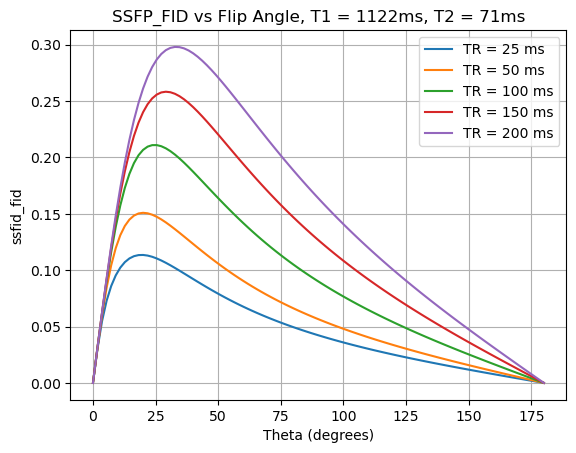

In [8]:
# Define the range of theta values
theta_values = np.linspace(0, 180, 100)  # Example range from 0 to 180 degrees

# Define the TR values
TR_values = [25, 50, 100, 150, 200]
M_0 = 1#10000.0
T2 = 71 # tissue
T1 = 1122 # tissue

for TR in TR_values:
    E_1 = np.exp(-TR/T1)  
    E_2 = np.exp(-TR/T2) 
    ssfid_fid_values = []
    for theta in theta_values:
        value = ssfp_fid(M_0, theta, E_1, E_2)
        ssfid_fid_values.append(value)


    plt.plot(theta_values, ssfid_fid_values, label=f'TR = {TR} ms')

plt.xlabel('Theta (degrees)')
plt.ylabel('ssfid_fid')
plt.title('SSFP_FID vs Flip Angle, T1 = 1122ms, T2 = 71ms')
plt.legend()
plt.grid(True)
plt.show()

In [56]:
from testhelperfunctions import ssfp_fid, calcSteadyStateMean
import sys
import numpy as np

sys.path.insert(0, "./functions/")
from DictionaryGeneratorFast import DictionaryGeneratorFast

# create a plot for a test theoretical TR, T1 and T2
M_0 = 10000 #10000.0
T2 =  71 #71 # tissue
T1 = 1300 #1122 # tissue
noRepetitions = 1000
TR = 25

# simulation parameters
readTRFA = False
samples = 1
dictionaryId = 'Discard'
instance = 25
noise = 1 # no noise
multi = 100
invSwitch = False
CSFnullswitch = False
sliceProfileSwitch = 0 # the original FISP slice profile
sequence = 'FISP'
t1Array = np.array([T1,T1]) # single compartment model
t2Array = np.array([T2,T2]) # single compartment model
t2StarArray = np.array([50,21])
res = 0 # not important in single compartment with no exchange
vb = 0 # not important in single compartment with no exchange
noOfIsochromatsX = 10000
noOfIsochromatsY = 1
noOfIsochromatsZ = 1
noOfRepetitions = 1000

simulated_signal_mean_steady_state = np.zeros(np.size(ssfp_fid_theoretical))
thetaidx = -1
# iterate through each theta value 
for theta in theta_values:
    thetaidx += 1
    faArray = np.ones(noRepetitions)*theta
    trArray = np.ones(noRepetitions)*TR

    # simulate the signal
    simulated_generator = DictionaryGeneratorFast(t1Array, t2Array, t2StarArray, noOfIsochromatsX,\
                noOfIsochromatsY, noOfIsochromatsZ, noOfRepetitions, noise, vb/10, res,\
                multi/100, invSwitch, CSFnullswitch, sliceProfileSwitch, samples, dictionaryId, sequence, instance, readTRFA, trArray, faArray)
    simulated_signal = simulated_generator.MRFSGRE()[:,0]
    # compute the steady state mean
    simulated_signal_mean_steady_state[thetaidx] = simulated_signal[-1] #calcSteadyStateMean(simulated_signal, gradient_threshold=0.1, plot = False, print_info = False)
    print(simulated_signal_mean_steady_state[thetaidx] )

0.0
167.21876648288458
320.63440558712534
452.76332815846547
562.8401368957128
653.5710643624478
728.403326891743
790.3500864389798
841.7503077896624
884.3628093513573
919.5204271294577
948.2596987548721
971.4130129043931
989.6699580530436
1003.6171359829808
1013.7638539245509
1020.5588274856249
1024.4012467193045
1025.648337083644
1024.6207514819155
1021.6066223761359
1016.8647829731975
1010.6274659172548
1003.102663085872
994.4762531737861
984.9139571053192
974.5631537124316
963.5545723826257
952.0038709408587
940.013102962371
927.6720771707143
915.0596114004679
902.2446840899731
889.2874869958347
876.2403835528095
863.1487779187624
850.0519001950249
836.9835135870445
823.9725493828619
811.0436756001659
798.2178050147021
785.5125480598664
772.9426158044821
760.520177893291
748.2551799903188
736.1556249125521
724.2278212901036
712.4766032479397
700.9055242778202
689.5170281612926
678.3125995175336
667.2928962844434
656.4578661978753
645.8068491118955
635.3386668015544
625.051701707798

In [54]:
# create a plot for a test theoretical TR, T1 and T2
M_0 = 10000 #10000.0
T2 = 71 # tissue
T1 = 1300 # tissue
noRepetitions = 1000
TR = 25

# Theoretical SS for variable theta (0-180 degrees) 
theta_values = np.linspace(0, 90, 91)
E_1_fixed = np.exp(-TR/ T1)
E_2_fixed = np.exp(-TR / T2)
ssfp_fid_theoretical= np.array([ssfp_fid(M_0, theta, E_1_fixed, E_2_fixed) for theta in theta_values])

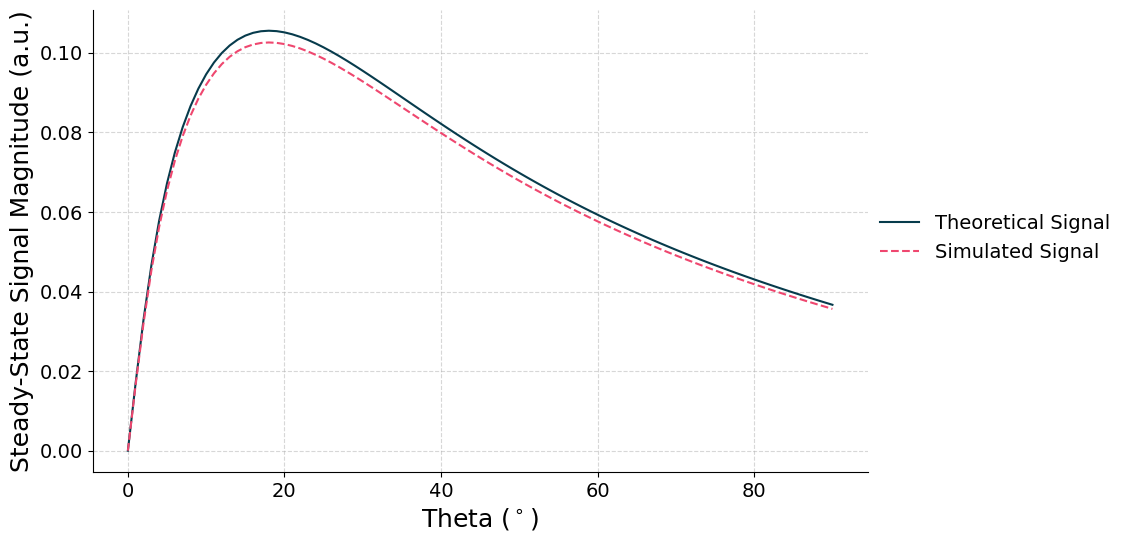

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Define the list of colors for plot
colors = ['#ef476f', '#f78c6b', '#ffd166', '#06d6a0', '#118ab2', '#073b4c']
# Set font family
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['DejaVu Sans']

fig, ax = plt.subplots(1, 1, figsize=(10,6), sharex=False)

# Plot the signals
ax.plot(ssfp_fid_theoretical/M_0, linestyle='-', color=colors[5], label='Theoretical Signal') 
ax.plot(simulated_signal_mean_steady_state/M_0, linestyle='--', color=colors[0], label='Simulated Signal')  
# Add labels and title
ax.set_xlabel('Theta ($^\circ$)', fontsize=18, color='k')
ax.set_ylabel('Steady-State Signal Magnitude (a.u.)', fontsize=18, color='k')
# Customize plots: Remove top and right spines, add grid
ax.grid(visible=True, linestyle='--', alpha=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=14)

# Create a shared legend outside both plots
fig.legend(
    loc='center right',
    fontsize=14,
    frameon=False,
    bbox_to_anchor=(1.16, 0.5)  # Position legend outside the figure
)
# Show the plot
plt.show()


/var/folders/g0/5d6w6vqx2yv2b3fqgwsh6xfr0000gn/T/ipykernel_5873/3916723850.py:1: RuntimeWarning: invalid value encountered in divide
  percentage_difference = ((simulated_signal_mean_steady_state - ssfp_fid_theoretical) / ssfp_fid_theoretical) * 100


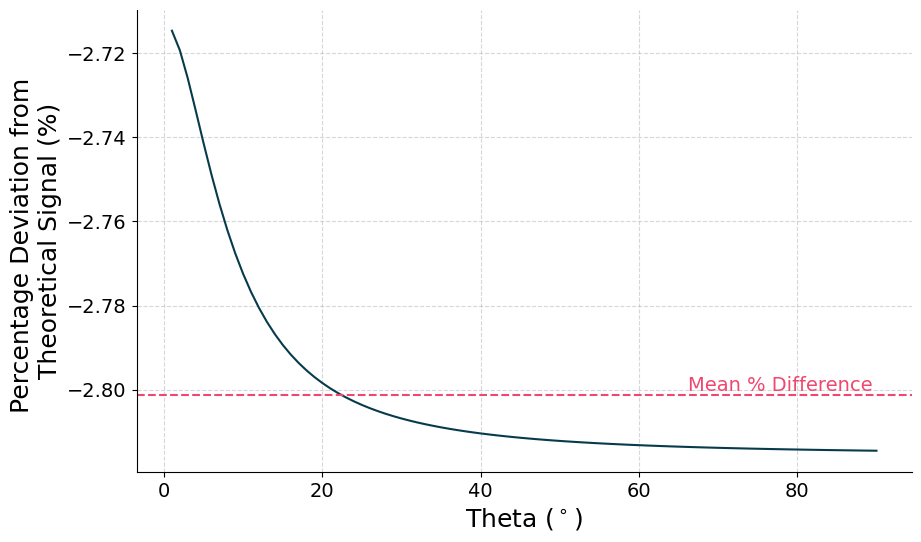

In [58]:
percentage_difference = ((simulated_signal_mean_steady_state - ssfp_fid_theoretical) / ssfp_fid_theoretical) * 100
fig, ax = plt.subplots(1, 1, figsize=(10,6), sharex=False)


ax.plot(percentage_difference, linestyle='-', color=colors[5])
mean_perc_diff = np.mean(percentage_difference[1:-1])
ax.axhline(mean_perc_diff,linestyle='--', color=colors[0])
ax.text(x=0.95, y=mean_perc_diff, s='Mean % Difference', color=colors[0], fontsize=14, 
        verticalalignment='bottom', horizontalalignment='right', transform=ax.get_yaxis_transform())
ax.set_xlabel('Theta ($^\circ$)', fontsize=18, color='k')
ax.set_ylabel('Percentage Deviation from \nTheoretical Signal (%)', fontsize=18, color='k')
# Customize plots: Remove top and right spines, add grid
ax.grid(visible=True, linestyle='--', alpha=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=14)



In [38]:
mean_perc_diff

-2.798591570532706

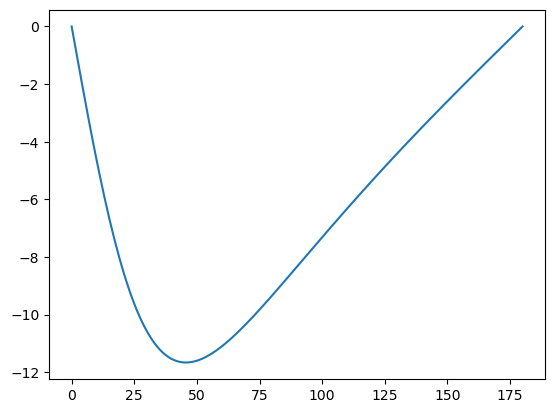

In [26]:
plt.plot(simulated_signal_mean_steady_state - ssfp_fid_theoretical)

In [25]:
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score

rmse = root_mean_squared_error(ssfp_fid_theoretical, simulated_signal_mean_steady_state)
r2 = r2_score(ssfp_fid_theoretical, simulated_signal_mean_steady_state)

In [9]:
rmse

75.09841380952538

In [26]:
r2

0.9972724844499319

In [ ]:
# Set the number of points
Nrf = 200
noOfRepetitions = 1000
cycles = noOfRepetitions/Nrf
faArray = []
min_angle = 5
inv = 1
#ßmaxFA = random.sample(range(5,90),int(cycles)) # random sample of flip angles
maxFA = [35-min_angle,43-min_angle,70-min_angle,45-min_angle,27-min_angle] # values from the paper
for i in range(int(cycles)):
    # Current random flip angle
    maxFA_i = maxFA[i]
    # Iterate through the segment
    for j in range(1,Nrf):
        # Calculate the flip angle
        flipAngle = np.sin(j*np.pi/Nrf)*maxFA_i
        # Append the flip angle to the array
        faArray.append(flipAngle+min_angle)
    faArray += [0,0,0,0,0,0,0,0,0,0]
faArray = faArray[:noOfRepetitions]

plt.plot(faArray)
plt.show()

if inv == 1:
    faArray[0] = 180



In [ ]:
print(faArray)

In [ ]:
faArrayorig = np.genfromtxt('fa_jiang', delimiter=',', dtype=float) 
plt.plot(faArrayorig[1:1000], label = 'orig')
plt.plot(faArray[1:], label = 'gen')
plt.legend()
plt.show()


In [ ]:
np.max(faArrayorig[800:1000])

In [ ]:
np.mean(faArrayorig[:1000]-faArray)

[180.  45.  45. ...  45.  45.  45.]


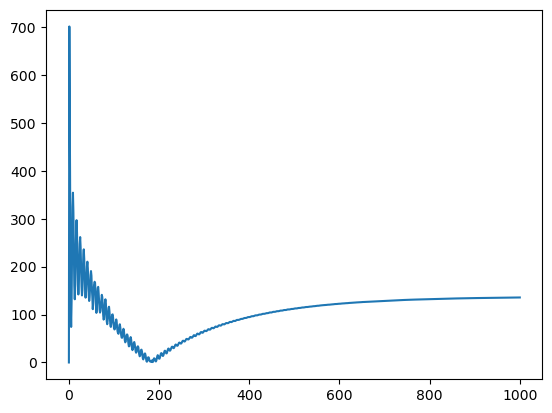

In [16]:
from testhelperfunctions import ssfp_fid, calcSteadyStateMean
import sys
import numpy as np

sys.path.insert(0, "./functions/")
from DictionaryGeneratorFast import DictionaryGeneratorFast

# create a plot for a test theoretical TR, T1 and T2
M_0 = 1000 #10000.0
T2 = 900 # tissue
T1 = 4300 # tissue #https://pmc.ncbi.nlm.nih.gov/articles/PMC6590483/#:~:text=(The%20T1%2C%20T2,60%20ms.19%E2%80%9021)
noRepetitions = 2000
TR = 13
theta_mean = 45

# Theoretical SS for variable theta (0-180 degrees) 
#E_1_fixed = np.exp(-TR/ T1)
#E_2_fixed = np.exp(-TR / T2)
#ssfp_fid_theoretical= [ssfp_fid(M_0, theta, E_1_fixed, E_2_fixed) for theta in theta_values]

# simulation parameters
readTRFA = False
samples = 1
dictionaryId = 'Discard'
instance = 25
noise = 1 # no noise
multi = 100
invSwitch = False
CSFnullswitch = False
sliceProfileSwitch = 0 # the original FISP slice profile
sequence = 'FISP'
t1Array = np.array([T1,T1]) # single compartment model
t2Array = np.array([T2,T2]) # single compartment model
t2StarArray = np.array([50,21])
res = 0 # not important in single compartment with no exchange
vb = 1 # not important in single compartment with no exchange
noOfIsochromatsX = 1000
noOfIsochromatsY = 1
noOfIsochromatsZ = 1
noOfRepetitions = 1001

thetaidx = -1

faArray = np.ones(noRepetitions-1)*theta_mean
faArray = np.insert(faArray,0,180)
trArray = np.ones(noRepetitions)*TR

# simulate the signal
simulated_generator = DictionaryGeneratorFast(t1Array, t2Array, t2StarArray, noOfIsochromatsX,\
            noOfIsochromatsY, noOfIsochromatsZ, noOfRepetitions, noise, vb/10, res,\
            multi/100, invSwitch, CSFnullswitch, sliceProfileSwitch, samples, dictionaryId, sequence, instance, readTRFA, trArray, faArray)
simulated_signal = simulated_generator.MRFSGRE()[:,0]

import matplotlib.pyplot as plt
plt.plot(simulated_signal)
origin, min = np.partition(simulated_signal, 1)[0:2] 

In [17]:
min

0.7994404314130282

In [18]:
np.where(simulated_signal == min)

(array([186]),)

In [19]:
186*13

2418

## Comparing to Jiang FISP

Text(1.23, 0.13, '$\\it{T}_{2}$ = 85ms')

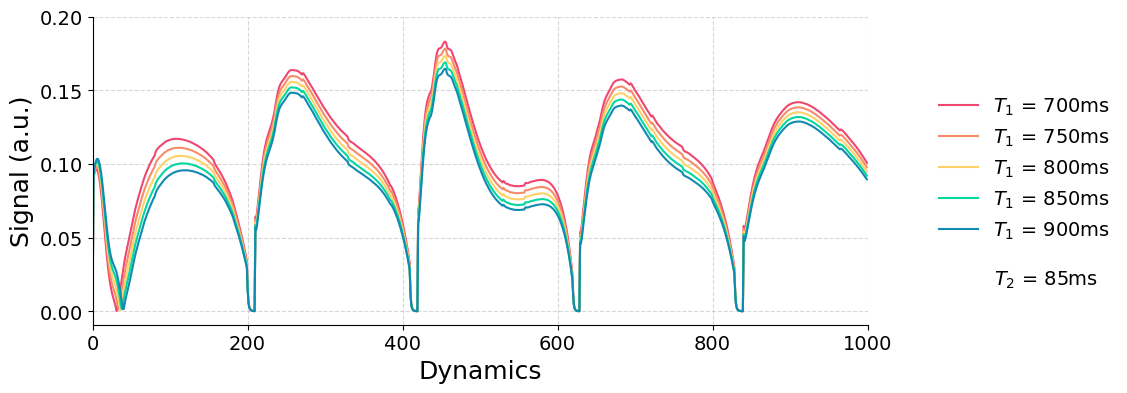

In [16]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np

# Define the list of colors for plot
colors = ['#ef476f', '#f78c6b', '#ffd166', '#06d6a0', '#118ab2', '#073b4c']
# Set font family
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['DejaVu Sans']

# Read in sequence data
sequence_T1_700 = np.load('/Users/ela/Documents/PhD/code/MRFSGRE_BBB/dictionaries/DictionaryFISP_orig/echo_700_700_85_85_200_0.0_1.0_1.npy') 
sequence_T1_750 = np.load('/Users/ela/Documents/PhD/code/MRFSGRE_BBB/dictionaries/DictionaryFISP_orig/echo_750_750_85_85_200_0.0_1.0_1.npy')
sequence_T1_800 = np.load('/Users/ela/Documents/PhD/code/MRFSGRE_BBB/dictionaries/DictionaryFISP_orig/echo_800_800_85_85_200_0.0_1.0_1.npy')
sequence_T1_850 = np.load('/Users/ela/Documents/PhD/code/MRFSGRE_BBB/dictionaries/DictionaryFISP_orig/echo_850_850_85_85_200_0.0_1.0_1.npy')
sequence_T1_900 = np.load('/Users/ela/Documents/PhD/code/MRFSGRE_BBB/dictionaries/DictionaryFISP_orig/echo_900_900_85_85_200_0.0_1.0_1.npy')

fig, ax = plt.subplots(1, 1, figsize=(10,4), sharex=False)

# Plot the sequence on line graph
ax.plot(sequence_T1_700/10000, label='$\it{T}_{1}$ = 700ms', color = colors[0]) # divide by 10000 to obtain same scale as Jiang paper (normalised)
ax.plot(sequence_T1_750/10000, label='$\it{T}_{1}$ = 750ms', color = colors[1]) 
ax.plot(sequence_T1_800/10000, label='$\it{T}_{1}$ = 800ms', color = colors[2]) 
ax.plot(sequence_T1_850/10000, label='$\it{T}_{1}$ = 850ms', color = colors[3]) 
ax.plot(sequence_T1_900/10000, label='$\it{T}_{1}$ = 900ms', color = colors[4]) 

# Customize plots: Remove top and right spines, add grid
ax.grid(visible=True, linestyle='--', alpha=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=14)


ax.set_xlabel('Dynamics', fontsize=18, color='k')
ax.set_ylabel('Signal (a.u.)', fontsize=18, color='k')
#plt.legend(loc='upper center',bbox_to_anchor=(0.5, 1.2), ncol=5, prop = { "size": 12 })
# Create a shared legend outside both plots
fig.legend(
    loc='center right',
    fontsize=14,
    frameon=False,
    bbox_to_anchor=(1.16, 0.5)  # Position legend outside the figure
)
plt.ylim = ([0,0.15])
plt.yticks([0.000,0.05, 0.1, 0.15, 0.2])
plt.xlim([0,1000])
plt.text(1.23, 0.13, '$\it{T}_{2}$ = 85ms', fontsize=14, ha='center', transform=plt.gca().transAxes)